In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optimizers
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

np.random.seed(98537)
torch.manual_seed(98537)

In [2]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False
    
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
# データの生成
# データの設定
k = 12
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
Lambda = np.random.gamma(40.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
N = np.sum(pt)

In [4]:
# idとインデックスの設定
# idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

# インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
# 素性ベクトルの生成
k1 = 2; k2 = 4; k3 = 4
x1 = np.random.normal(0.0, 0.5, k1*N).reshape(N, k1)
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.hstack((np.repeat(1.0, N)[:, np.newaxis], x1, x2, x3))
col = x.shape[1]

In [6]:
# アイテムの生成
# 多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_topic = np.random.dirichlet(np.repeat(0.2, item), topic)
z = rmnom(theta_topic[d_id, ], N, topic, 0)

# トピックからアイテムを生成
item_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    item_id[index] = rmnom(phi_topic[z[d_list[i]], ], pt[i], item, 0)
    
# インデックスの設定
item_list = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]

In [7]:
# 応答変数の生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    
    # 階層モデルのパラメータを生成
    alpha = 0.0
    alpha_u = np.repeat(0.0, k)
    alpha_v = np.repeat(0.0, k)
    Cov_u = np.diag(np.append(0.5, np.repeat(1.0, k)))
    Cov_v = np.diag(np.append(0.7, np.repeat(1.0, k)))
    Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

    # モデルパラメータを生成
    beta = np.append(-1.0, np.random.normal(0.0, 0.7, col-1))
    beta_u = np.random.normal(0.0, Cov_u[0, 0], hh)
    beta_v = np.random.normal(0.0, Cov_v[0, 0], item)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u[1:, 1:], hh)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v[1:, 1:], item)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy()
        
    # モデルの期待値
    beta_mu = np.dot(x, beta)
    uv = np.sum(theta_u[d_id, ] * theta_v[item_id, ], axis=1)
    mu = beta_u[d_id] + beta_v[item_id] + beta_mu + uv
    
    #ベルヌーイ分布から応答変数を生成
    Prob = np.exp(mu) / (1 + np.exp(mu))
    y = np.random.binomial(1, Prob, N)
    y_vec = y[:, np.newaxis]

    #break条件
    if (np.mean(y) > 0.2) & (np.mean(y) < 0.4):
        break

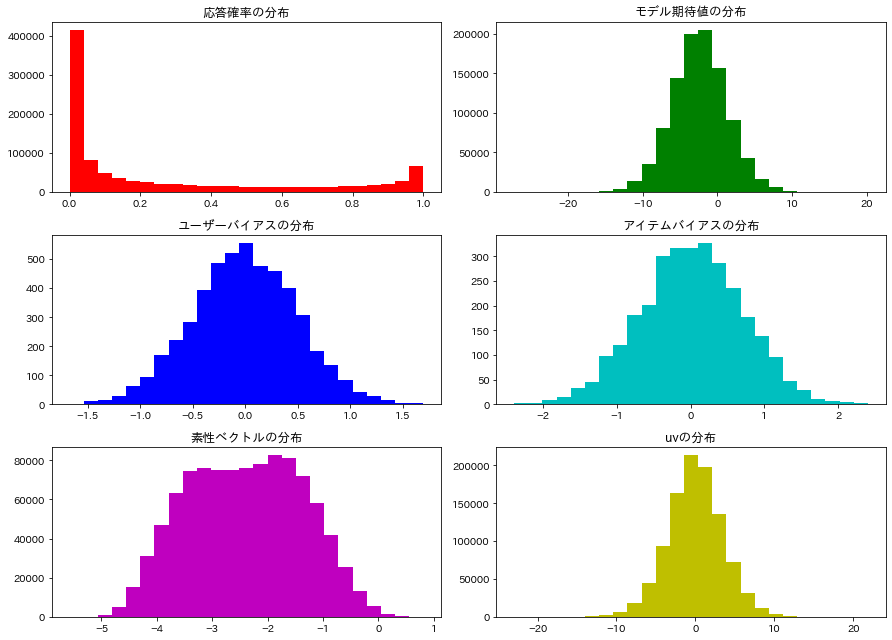

In [8]:
#潜在変数ごとのヒストグラム
dt = [Prob, mu, beta_u, beta_v, beta_mu, uv]
fig_range = np.append(np.array([0, np.min(mu), np.min(beta_u), np.min(beta_v), np.min(beta_mu), np.min(uv)]), 
                      np.array([1.0, np.max(mu), np.max(beta_u), np.max(beta_v), np.max(beta_mu), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーバイアスの分布", "アイテムバイアスの分布", "素性ベクトルの分布", "uvの分布"]
fig = plt.figure(figsize=(12.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(3, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [9]:
# テストデータの生成
# ユーザーidの生成
m = np.random.poisson(np.random.gamma(40.0, 1/0.2, hh))
M = np.sum(m)
d_id0 = np.repeat(np.arange(hh), m)

# インデックスの設定
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

# 素性ベクトルを生成
x1 = np.random.normal(0.0, 0.5, k1*M).reshape(M, k1)
x2 = np.zeros((M, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, M)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), M)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x0 = np.hstack((np.repeat(1.0, M)[:, np.newaxis], x1, x2, x3))

# アイテムの生成
# 多項分布からトピックを生成
z = rmnom(theta_topic[d_id0, ], M, topic, 0)

# トピックからアイテムを生成
item_id0 = np.repeat(0, M)
for i in range(hh):
    index = d_list0[i]
    item_id0[index] = rmnom(phi_topic[z[d_list0[i]], ], m[i], item, 0)

In [10]:
# 応答変数の生成
# モデルの期待値
beta_mu = np.dot(x0, beta)
uv = np.sum(theta_u[d_id0, ] * theta_v[item_id0, ], axis=1)
mu = beta_u[d_id0] + beta_v[item_id0] + beta_mu + uv

# ベルヌーイ分布から応答変数を生成
Prob = np.exp(mu) / (1 + np.exp(mu))
y0 = np.random.binomial(1, Prob, M)
y_vec0 = y0[:, np.newaxis]

In [11]:
# 対数尤度の基準値
# 学習データの1パラメータモデルの対数尤度
Prob = np.mean(y)
LLst1 = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLst1)

# 学習データに対する真値の対数尤度
mut = betat_u[d_id] + betat_v[item_id] + np.dot(x, betat) + np.dot(thetat_u[d_id, ] * thetat_v[item_id, ], k_vec)
Prob = np.exp(mut) / (1 + np.exp(mut))
LLbest1 = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLbest1)

# テストデータの1パラメータモデルの対数尤度
Prob = np.mean(y0)
LLst0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
print(LLst0)

# テストデータに対する真値の対数尤度
mut = betat_u[d_id0] + betat_v[item_id0] + np.dot(x0, betat) + np.dot(thetat_u[d_id0, ] * thetat_v[item_id0, ], k_vec)
Prob = np.exp(mut) / (1 + np.exp(mut))
LLbest0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
print(LLbest0)

-586847.0695639974
-263548.19956509885
-589723.0660189205
-264481.3484229034


In [12]:
# モデルの定義
class LRLF(nn.Module):
    def __init__(self, col, k, hh, item):
        super().__init__()
        self.beta = nn.Linear(in_features=col, out_features=1, bias=False)
        self.beta_u = nn.Embedding(num_embeddings=hh, embedding_dim=1)
        self.beta_v = nn.Embedding(num_embeddings=item, embedding_dim=1)
        self.theta_u = nn.Embedding(num_embeddings=hh, embedding_dim=k)
        self.theta_v = nn.Embedding(num_embeddings=item, embedding_dim=k)
        self.mu = nn.Linear(in_features=1, out_features=1, bias=False)
        
    def forward(self, x, d_id, item_id, N):
        beta_mu = self.beta(x)
        beta_user = self.beta_u(d_id)
        beta_item = self.beta_v(item_id)
        uv = (self.theta_u(d_id) * self.theta_v(item_id)).sum(1).reshape(N, 1)
        mu = self.mu(beta_mu + beta_user + beta_item + uv)
        return mu
    
# 負の対数尤度関数を定義
def loglike(y, mu):
    logit_exp = torch.exp(mu)
    Prob = logit_exp / (1 + logit_exp)
    Prob[Prob==1.0, ] = 0.999999; Prob[Prob==0.0, ] = 10.0**-10.0
    Lho = y*torch.log(Prob) + (1-y)*torch.log(1-Prob)
    return -Lho.sum()

In [13]:
# モデルの学習
# アルゴリズムの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LRLF(col, k, hh, item).to(device)
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer = optimizers.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), amsgrad=True, weight_decay=0.1)

def compute_loss(t, y):
    return criterion(t, y)

def train_step(y, x, d_id, item_id, model, optimizer):
    model.train()
    mu = model(x, d_id, item_id, x.shape[0])
    Lho = compute_loss(mu.reshape(-1), y)
    optimizer.zero_grad()
    Lho.backward()
    optimizer.step()
    return Lho, mu

def val_step(y0, x0, d_id0, item_id0, model):
    model.eval()
    mu = model(x0, d_id0, item_id0, x0.shape[0])
    Lho = compute_loss(mu.reshape(-1), y0)
    return Lho, mu

# モデルの設定
epochs = 50
batch_size = 10000
n_batches_train = N // batch_size
n_batches_val = M // batch_size
es = EarlyStopping(patience=5, verbose=1)
hist = {"train_loglike": [], "val_loglike" : []}

# データの定義
x_ = torch.Tensor(x).to(device)
y_ = torch.Tensor(y).to(device)
d_id_ = torch.LongTensor(d_id).to(device)
item_id_ = torch.LongTensor(item_id).to(device)

In [ ]:
# tensor型の配列を定義
x = torch.Tensor(x).to(device)
y = torch.Tensor(y).to(device)
d_id = torch.LongTensor(d_id).to(device)
item_id = torch.LongTensor(item_id).to(device)
x0 = torch.Tensor(x0).to(device)
y0 = torch.Tensor(y0).to(device)
d_id0 = torch.LongTensor(d_id0).to(device)
item_id0 = torch.LongTensor(item_id0).to(device)

# 確率的勾配法でモデルを推定
for rp in range(epochs):
    
    # データの定義
    random_index = np.argsort(np.random.uniform(0, 1, N))
    x_ = x[random_index, ]
    y_ = y[random_index]
    d_id_ = d_id[random_index]
    item_id_ = item_id[random_index]

    # パラメータを更新
    preds_train = np.array([])
    for batch in range(n_batches_train):
        start = batch * batch_size
        if batch==n_batches_train-1:
            end = x.shape[0]
        else:
            end = start + batch_size
        Lho, mu = train_step(y_[start:end], x_[start:end, ], d_id_[start:end, ], item_id_[start:end, ], model, optimizer)
        preds_train = np.append(preds_train, mu.detach().numpy().reshape(-1))

    # 学習データの対数尤度を更新
    preds_ = torch.Tensor(preds_train).to(device)
    train_loglike = -loglike(y_, preds_)
    hist["train_loglike"].append(train_loglike.numpy())
    
    
    # テストデータの予測値を更新
    preds_val = np.array([])
    for batch in range(n_batches_val):
        start = batch * batch_size
        if batch==n_batches_train-1:
            end = x0.shape[0]
        else:
            end = start + batch_size
        Lho, mu = val_step(y0[start:end], x0[start:end], d_id0[start:end], item_id0[start:end], model)
        preds_val = np.append(preds_val, mu.detach().numpy().reshape(-1))
    
    # テストデータの対数尤度を更新
    preds_ = torch.Tensor(preds_val).to(device)
    val_loglike = -loglike(y0, preds_)
    hist["val_loglike"].append(val_loglike.numpy())
    
    # 学習結果を表示
    print(rp)
    print(np.round([train_loglike.numpy(), val_loglike.numpy()], 1))
    
    # 早期終了
    if es(-val_loglike)==True:
        break